In [1]:
import matplotlib as mlp
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib.dates as mdates

In [2]:
# 유니코드 깨짐현상 해결
mlp.rcParams['axes.unicode_minus'] = False

# 나눔고딕 폰트 적용
mlp.rcParams["font.family"] = 'NanumGothic'

In [3]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from haversine import haversine

In [5]:
%%time
mybicard = pd.read_parquet('/home/seho/Passenger_Demand/data/mybicard.parquet', engine='pyarrow')

CPU times: user 23.1 s, sys: 5.36 s, total: 28.5 s
Wall time: 14.5 s


In [6]:
%%time
mybicard = mybicard.drop_duplicates()

CPU times: user 41.5 s, sys: 3.42 s, total: 45 s
Wall time: 44.9 s


In [7]:
# 수집일자 데이트 포맷으로 변환
mybicard["collectdate"] = pd.to_datetime(mybicard["collectdate"], format = "%Y%m%d")

In [8]:
# 전송일자 데이트 포맷으로 변환
mybicard["transdate"] = pd.to_datetime(mybicard["transdate"], format = "%Y%m%d %H:%M:%S")

In [9]:
# 요일, 날짜, 월 변수 생성
mybicard["dayofweek"] = mybicard["transdate"].dt.dayofweek
dow_dict = {0:"월", 1:"화", 2:"수", 3:"목", 4:"금", 5:"토", 6:"일"}
mybicard["dayofweek"] = mybicard["dayofweek"].replace(dow_dict)
mybicard["day"] = mybicard["transdate"].dt.day
mybicard["month"] = mybicard["transdate"].dt.month
mybicard["hour"] = mybicard["transdate"].dt.hour

In [10]:
# 전체 승객 수 변수 생성(일반 + 학생 + 아동)
mybicard["totalcnt"] = mybicard[["normalcnt", "studentcnt", "childcnt"]].sum(axis = 1)

In [11]:
# route_nm에 공백이 포함되어 있어 공백 제거
mybicard["route_nm"] = mybicard["route_nm"].replace("\s", "", regex = True)

In [12]:
mybicard = mybicard.sort_values(["transdate", "seq"]).reset_index(drop=True)

In [13]:
mybicard = mybicard.rename(columns = {"stop_id" : "mybi_stop_id"})

In [15]:
mybicard.dtypes

collectdate       datetime64[ns]
seq                        int64
route_nm                  object
transdate         datetime64[ns]
sumamount                  int64
stop_nm                   object
mybi_stop_id               int64
normalcnt                  int64
studentcnt                 int64
studentamount              int64
childcnt                   int64
childamount                int64
transflag                 object
mybicardnumber            object
base_ymd                   int64
dayofweek                 object
day                        int64
month                      int64
hour                       int64
totalcnt                   int64
dtype: object

In [17]:
mybicard.head()

collectdate     seq route_nm           transdate  sumamount stop_nm  \
0  2020-04-08   52570     5005 2020-04-08 00:00:04       4100  KTX울산역   
1  2020-04-08  117584     1723 2020-04-08 00:00:07       2080    메가마트   
2  2020-04-07  117283     1137 2020-04-08 00:00:15       2080   덕계사거리   
3  2020-04-07   62493     1137 2020-04-08 00:00:17       2080   덕계사거리   
4  2020-04-07   62181     1137 2020-04-08 00:00:24       2080   덕계사거리   

   stop_id  normalcnt  studentcnt  studentamount  childcnt  childamount  \
0  3103519          1           0              0         0            0   
1  3101906          1           0              0         0            0   
2  3100497          1           0              0         0            0   
3  3100497          1           0              0         0            0   
4  3100497          1           0              0         0            0   

  transflag mybicardnumber  base_ymd dayofweek  day  month  total_cnt  
0       비환승  D900620529618  20200408         수    8      4          1  
1       비환승  D900620938598  20200408         수    8      4          1  
2       비환승  D900602918559  20200408         수    8      4          1  
3       비환승  D900558190326  20200408         수    8      4          1  
4       비환승  D900519485518  20200408         수    8      4          1

## 1. 날짜 확인

In [38]:
count_by_date = mybicard.groupby(pd.Grouper(key="transdate", freq="1D")).size().reset_index()
count_by_date.columns = ["transdate", "cnt"]

In [422]:
count_by_date["transdate"].min()

Timestamp('2020-04-08 00:00:00')

In [423]:
count_by_date["transdate"].max()

Timestamp('2020-11-30 00:00:00')

#### 빠진 날짜 

In [400]:
count_by_date.shape

(237, 2)

In [39]:
count_by_date.loc[count_by_date["cnt"] == 0]

transdate  cnt
7   2020-04-15    0
8   2020-04-16    0
9   2020-04-17    0
10  2020-04-18    0
11  2020-04-19    0
14  2020-04-22    0
21  2020-04-29    0
22  2020-04-30    0
27  2020-05-05    0
29  2020-05-07    0
36  2020-05-14    0
40  2020-05-18    0
43  2020-05-21    0
45  2020-05-23    0
48  2020-05-26    0
52  2020-05-30    0
53  2020-05-31    0
124 2020-08-10    0
132 2020-08-18    0
136 2020-08-22    0
141 2020-08-27    0
142 2020-08-28    0
190 2020-10-15    0
191 2020-10-16    0
192 2020-10-17    0
193 2020-10-18    0
194 2020-10-19    0
195 2020-10-20    0
196 2020-10-21    0
197 2020-10-22    0
198 2020-10-23    0
199 2020-10-24    0
200 2020-10-25    0
201 2020-10-26    0
202 2020-10-27    0
203 2020-10-28    0
205 2020-10-30    0
207 2020-11-01    0
212 2020-11-06    0
215 2020-11-09    0
216 2020-11-10    0
217 2020-11-11    0
218 2020-11-12    0
219 2020-11-13    0
220 2020-11-14    0
221 2020-11-15    0
222 2020-11-16    0

In [399]:
count_by_date.loc[count_by_date["cnt"] == 0].to_csv("빠진 날짜.csv")

## 2. 버스 수
577개의 노선 (버스 번호)

In [405]:
bus_cnt = mybicard["route_nm"].value_counts().reset_index()
bus_cnt.columns = ["bus_no", "cnt"]

In [406]:
plt.figure(figsize=(15,8))
bus_cnt.head(20).plot.bar(x = "bus_no")

<AxesSubplot:xlabel='bus_no'>

<Figure size 1080x576 with 0 Axes>

In [407]:
grp_cnt = mybicard.groupby(["dayofweek", "route_nm"]).size().reset_index()
grp_cnt.rename(columns={0:"cnt"}, inplace=True)

In [408]:
grp_cnt = grp_cnt.sort_values(["dayofweek", "cnt"], ascending = False)
grp_cnt_top = grp_cnt.groupby(["dayofweek"]).head(10).reset_index(drop = True)

In [409]:
grp_cnt_top.head()

dayofweek route_nm     cnt
0         화      401  321504
1         화      127  274264
2         화      106  219989
3         화      104  170372
4         화      216  154910

In [410]:
grp_cnt_top = grp_cnt_top.set_index("dayofweek").loc[["월", "화", "수", "목", "금", "토", "일"]].reset_index()

In [415]:
grp_cnt_top.loc[grp_cnt_top["dayofweek"].isin(["월", "일"])]

dayofweek route_nm     cnt
0          월      401  321395
1          월      127  272530
2          월      106  216284
3          월      104  167543
4          월      216  155580
5          월      133  141909
6          월      307  125211
7          월      124  121813
8          월      402  118985
9          월      432  113952
60         일      401  163348
61         일      127  119385
62         일      106  112382
63         일      104   84308
64         일      216   83596
65         일      133   83595
66         일      402   77683
67         일      307   68466
68         일      124   61196
69         일      412   54375

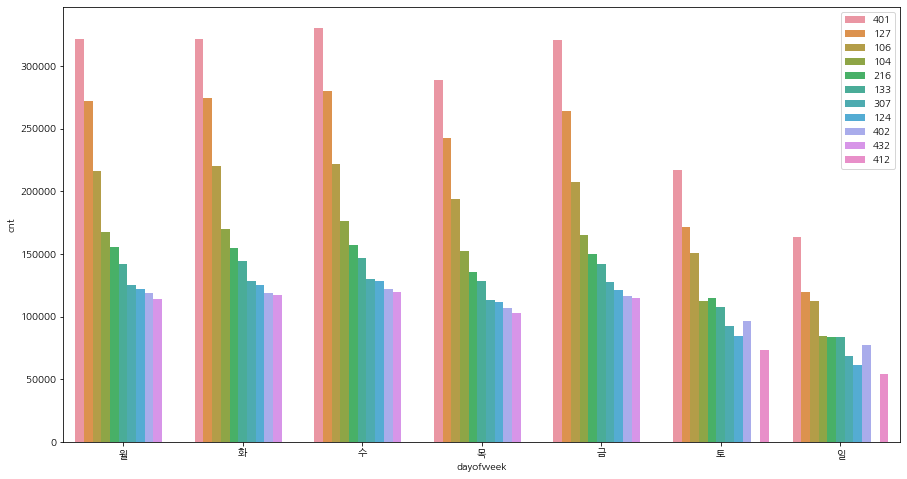

In [413]:
# 요일별로 타는 버스의 패턴은 동일함
plt.figure(figsize=(15,8))
sns.set_palette("deep")
sns.barplot(data = grp_cnt_top, x = "dayofweek", y = "cnt", hue = "route_nm")
plt.legend(loc='upper right')

## 2. 정류장 수
stop_id 수 : 3479 \
stop_nm 수 : 1801 \
stop_nm에 여러 id가 포함된 건수 : 1485

In [282]:
%%time
stop_nm_id_unq = mybicard.groupby("stop_nm")["stop_id"].nunique().reset_index()
stop_nm_id_unq.columns = ["stop_nm", "stop_id_nunq"]

CPU times: user 6.75 s, sys: 429 ms, total: 7.18 s
Wall time: 7.2 s


In [283]:
# 하나의 stop_nm에 여러 id가 포함된 건수
stop_nm_id_unq.loc[stop_nm_id_unq["stop_id_nunq"]>=2,]

stop_nm  stop_id_nunq
0          (?)??             2
3     (?)TCT?2??             2
5     (주)TCT제2공장             2
7          (주)리한             2
14       ?.?????             2
...          ...           ...
1794    효정고등학교입구             2
1795    효청보건고등학교             2
1796          후리             2
1799  휴먼시아.엘크루정문             2
1800     휴먼시아아파트             2

[1485 rows x 2 columns]

In [25]:
mybicard["stop_nm"].value_counts()

공업탑          1311593
시외고속버스터미널     940025
신정시장          596216
신복로터리         558070
?????         538057
              ...   
양등                 1
장천마을               1
디아채                1
옥천암입구              1
현대글로비스             1
Name: stop_nm, Length: 1801, dtype: int64

In [26]:
mybicard["stop_id"].value_counts()

3101421    638661
3101418    496063
3101525    391852
3101347    382185
3101460    370028
            ...  
3103964         1
9103714         1
3101971         1
3103045         1
3103966         1
Name: stop_id, Length: 3479, dtype: int64

## 3. Unique 마이비 카드 id
115,286 \
(참고) 21년 2월 기준 울산광역시 인구 : 113만 2,953명

In [7]:
len(mybicard["mybicardnumber"].unique())

1152876

### 요일별 평균 이용 횟수

In [72]:
day_cnt = mybicard.groupby(["dayofweek"]).agg({"totalcnt" : sum}).reset_index()

In [82]:
day_cnt = day_cnt.set_index("dayofweek").loc[["월", "화", "수", "목", "금", "토", "일"]].reset_index()

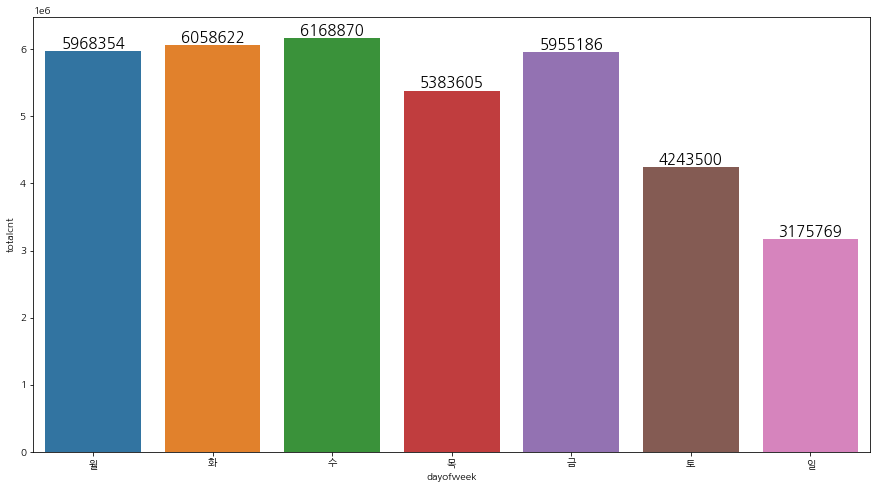

In [112]:
plt.figure(figsize=(15,8))
g = sns.barplot(data = day_cnt, x = "dayofweek", y = "totalcnt")
for _, r in day_cnt.iterrows():
    g.text(r.name, r.totalcnt + 50000, r.totalcnt, color='black', ha="center", size = 15 )

## 401번 버스

### 1. 401번 버스에 대한 데이터

In [14]:
mybicard_401 = mybicard.loc[(mybicard["route_nm"] == "401")].reset_index()

### 정류장 ID 찾기

In [363]:
mybicard_401.loc[(mybicard_401["mybicardnumber"] == "D900608681939") & (mybicard_401["transdate"].dt.date == pd.Timestamp(year=2020,month=4, day = 10))]

index collectdate     seq route_nm           transdate  sumamount  \
25279  442944  2020-04-10   33168      401 2020-04-10 15:37:13          0   
25361  444509  2020-04-10  101980      401 2020-04-10 15:44:57          0   

       stop_nm  stop_id  normalcnt  studentcnt  studentamount  childcnt  \
25279      공업탑  3101418          1           0              0         0   
25361  보건환경연구원  3100106          1           0              0         0   

       childamount transflag mybicardnumber  base_ymd dayofweek  day  month  \
25279            0        환승  D900608681939  20200410         금   10      4   
25361            0        하차  D900608681939  20200410         금   10      4   

       total_cnt  
25279          1  
25361          1

In [365]:
mybicard_401.loc[(mybicard_401["route_nm"] == "401") & (mybicard_401["stop_nm"] == "남목1동행정복지센터") & (mybicard_401["transflag"] == "하차")]

index collectdate     seq route_nm           transdate  sumamount  \
11686      202415  2020-04-09   12733      401 2020-04-09 08:43:01          0   
35317      622178  2020-04-11    1719      401 2020-04-11 18:19:09          0   
148520    2604796  2020-05-01   23545      401 2020-05-01 23:16:12          0   
221219    3918511  2020-05-12  150913      401 2020-05-12 08:02:12          0   
368730    6572729  2020-06-01   48446      401 2020-06-01 12:52:55          0   
440181    7938707  2020-06-08  187546      401 2020-06-08 08:03:53          0   
443298    8000497  2020-06-08  180710      401 2020-06-08 12:36:21          0   
542140    9903221  2020-06-17   22083      401 2020-06-17 10:59:01          0   
675061   12485540  2020-06-29  108485      401 2020-06-29 15:56:51          0   
675062   12485542  2020-06-29  133178      401 2020-06-29 15:56:52          0   
675063   12485549  2020-06-29   12827      401 2020-06-29 15:56:54          0   
701216   13000938  2020-07-01  232304      401 2020-07-01 18:11:26          0   
882728   16414967  2020-07-17   39107      401 2020-07-17 15:22:29          0   
894636   16633605  2020-07-18   52915      401 2020-07-18 14:58:15          0   
1104565  20576173  2020-08-06  103416      401 2020-08-06 22:03:08          0   
1180753  21969570  2020-08-14   11056      401 2020-08-14 20:28:43          0   
1234223  22928038  2020-08-21  153634      401 2020-08-21 11:40:27          0   
1297019  24032519  2020-08-31   28705      401 2020-08-31 08:49:45          0   
1387269  25667984  2020-09-10  199232      401 2020-09-10 09:52:34          0   
1469277  27195511  2020-09-18  189162      401 2020-09-18 16:19:27          0   
1568929  28994473  2020-09-28  194621      401 2020-09-28 10:42:24          0   
1568930  28994523  2020-09-28  176489      401 2020-09-28 10:42:38          0   
1582211  29231041  2020-09-29   61277      401 2020-09-29 11:12:27          0   
1687990  31100487  2020-10-11   88873      401 2020-10-11 19:35:37          0   
1704235  31377433  2020-10-13  115739      401 2020-10-13 08:19:26          0   
1781421  32746305  2020-11-04  190879      401 2020-11-04 10:10:19          0   
1793744  32960793  2020-11-05  219269      401 2020-11-05 08:31:22          0   

            stop_nm  stop_id  normalcnt  studentcnt  studentamount  childcnt  \
11686    남목1동행정복지센터  3100101          1           0              0         0   
35317    남목1동행정복지센터  3100101          1           0              0         0   
148520   남목1동행정복지센터  3100101          1           0              0         0   
221219   남목1동행정복지센터  3100101          1           0              0         0   
368730   남목1동행정복지센터  3100101          1           0              0         0   
440181   남목1동행정복지센터  3100101          1           0              0         0   
443298   남목1동행정복지센터  3100101          1           0              0         0   
542140   남목1동행정복지센터  3100101          1           0              0         0   
675061   남목1동행정복지센터  3100101          1           0              0         0   
675062   남목1동행정복지센터  3100101          1           0              0         0   
675063   남목1동행정복지센터  3100101          1           0              0         0   
701216   남목1동행정복지센터  3100101          1           0              0         0   
882728   남목1동행정복지센터  3100101          1           0              0         0   
894636   남목1동행정복지센터  3100101          1           0              0         0   
1104565  남목1동행정복지센터  3100101          1           0              0         0   
1180753  남목1동행정복지센터  3100101          1           0              0         0   
1234223  남목1동행정복지센터  3100101          1           0              0         0   
1297019  남목1동행정복지센터  3100101          1           0              0         0   
1387269  남목1동행정복지센터  3100101          1           0              0         0   
1469277  남목1동행정복지센터  3100101          1           0              0         0   
1568929  남목1동행정복지센터  3100101          1           0            

In [361]:
mybicard_401.loc[(mybicard_401["transdate"].dt.hour.between(2,6)) & (mybicard_401["stop_nm"] == "보건환경연구원")].sort_values("transdate")

index collectdate     seq route_nm           transdate  sumamount  \
1440583  26666778  2020-09-16  201484      401 2020-09-16 06:53:55          0   
1537502  28420514  2020-09-25   41823      401 2020-09-25 06:33:50          0   
1654544  30487865  2020-10-08  182481      401 2020-10-08 06:29:32          0   
1654753  30490928  2020-10-08   24329      401 2020-10-08 06:50:39          0   
1728579  31803830  2020-10-29   42155      401 2020-10-29 06:47:54          0   
1751712  32219098  2020-11-02  188541      401 2020-11-02 06:36:11          0   

         stop_nm  stop_id  normalcnt  studentcnt  studentamount  childcnt  \
1440583  보건환경연구원  3100106          1           0              0         0   
1537502  보건환경연구원  3100106          1           0              0         0   
1654544  보건환경연구원  3100106          1           0              0         0   
1654753  보건환경연구원  3100106          1           0              0         0   
1728579  보건환경연구원  3100106          1           0              0         0   
1751712  보건환경연구원  3100106          1           0              0         0   

         childamount transflag mybicardnumber  base_ymd dayofweek  day  month  \
1440583            0        하차  D900612762975  20200916         수   16      9   
1537502            0        하차  D900612762975  20200925         금   25      9   
1654544            0        하차  D900612762975  20201008         목    8     10   
1654753            0        하차  D900634151702  20201008         목    8     10   
1728579            0        하차  D900620888799  20201029         목   29     10   
1751712            0        하차  D900649548185  20201102         월    2     11   

         total_cnt  
1440583          1  
1537502          1  
1654544          1  
1654753          1  
1728579          1  
1751712          1

In [367]:
mybicard_401.loc[mybicard_401["stop_nm"].str.contains("남목1동행정복지센터"), ["stop_nm", "stop_id"]].drop_duplicates()

stop_nm  stop_id
234  남목1동행정복지센터  3100101

In [241]:
mybicard_401.iloc[[17278,23707]]

index collectdate     seq route_nm           transdate  sumamount  \
17278  3323395  2020-05-08  192948      401 2020-05-08 13:59:55       1250   
23707  3435335  2020-05-08   90067      401 2020-05-08 22:28:36       1250   

      stop_nm  stop_id  normalcnt  studentcnt  studentamount  childcnt  \
17278     정수장  3101392          1           0              0         0   
23707     정수장  3101405          1           0              0         0   

       childamount transflag mybicardnumber  base_ymd dayofweek  day  month  \
17278            0       비환승  D900026156174  20200508         금    8      5   
23707            0       비환승  D100592915827  20200508         금    8      5   

       total_cnt  
17278          1  
23707          1

### 401번 버스의 정류장별 탑승 횟수

In [ ]:
stop_cnt_401 = mybicard_401.groupby(["stop_id", "stop_nm"])["total_cnt"].sum().reset_index()

<AxesSubplot:xlabel='stop_nm', ylabel='total_cnt'>

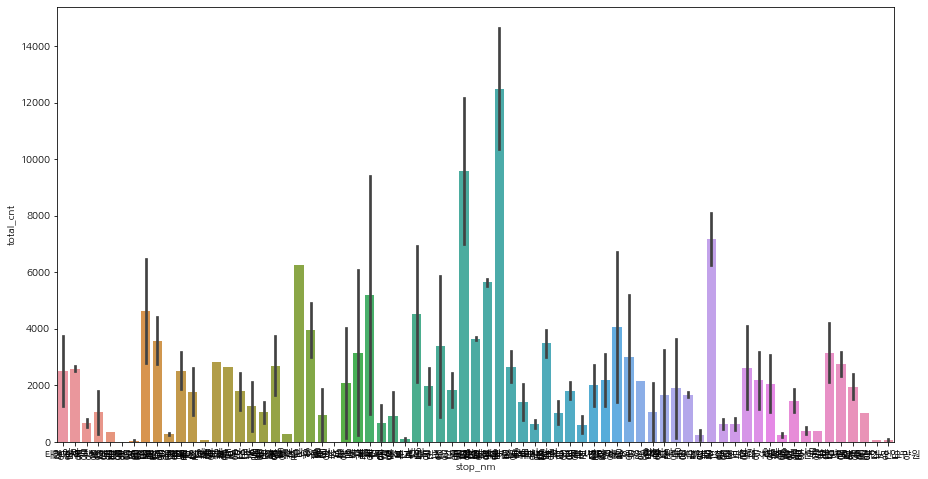

In [85]:
plt.figure(figsize=(15,8))
sns.barplot(data = stop_cnt_401, x = "stop_nm", y = "total_cnt")

In [70]:
len(mybicard_401["stop_nm"].unique())

69

### 401번 버스의 요일별 탑승인원 (10분 간격)

#### 10분 단위 탑승자 집계

In [94]:
# 21948
mybicard_401_agg_10m = (mybicard_401.loc[(mybicard_401["transflag"] != "하차")]
                                   .groupby(["route_nm", 
                                             pd.Grouper(key="transdate", freq='10Min')])
                                   .agg({"totalcnt" : sum})
                                   .reset_index())

In [273]:
def plot_week_cnt(data, start_dt = "2020-04-20"):
    data_grp = (data.loc[(data["transflag"] != "하차")]
                    .groupby(["route_nm", 
                              pd.Grouper(key="transdate", freq='10Min')])
                    .agg({"totalcnt" : sum})
                    .reset_index())
    

    start_dt = datetime.strptime(start_dt, "%Y-%m-%d") + timedelta(hours=5)
    end_dt = start_dt + timedelta(days=6, hours = 19)
    
    data_grp = data_grp.loc[data_grp["transdate"].between(start_dt,
                                                          end_dt)]    
    
    plt.figure(figsize=(30,8))
    g = sns.lineplot(data = data_grp, x = "transdate", y = "totalcnt")
    
    g.set(xlim=(start_dt - timedelta(hours=5,minutes=30), end_dt + timedelta(hours=5)))
    g.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
    g.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M\n'))
    g.xaxis.set_major_locator(mdates.DayLocator())
    g.xaxis.set_major_formatter(mdates.DateFormatter('\n%b %d'))

    plt.show()

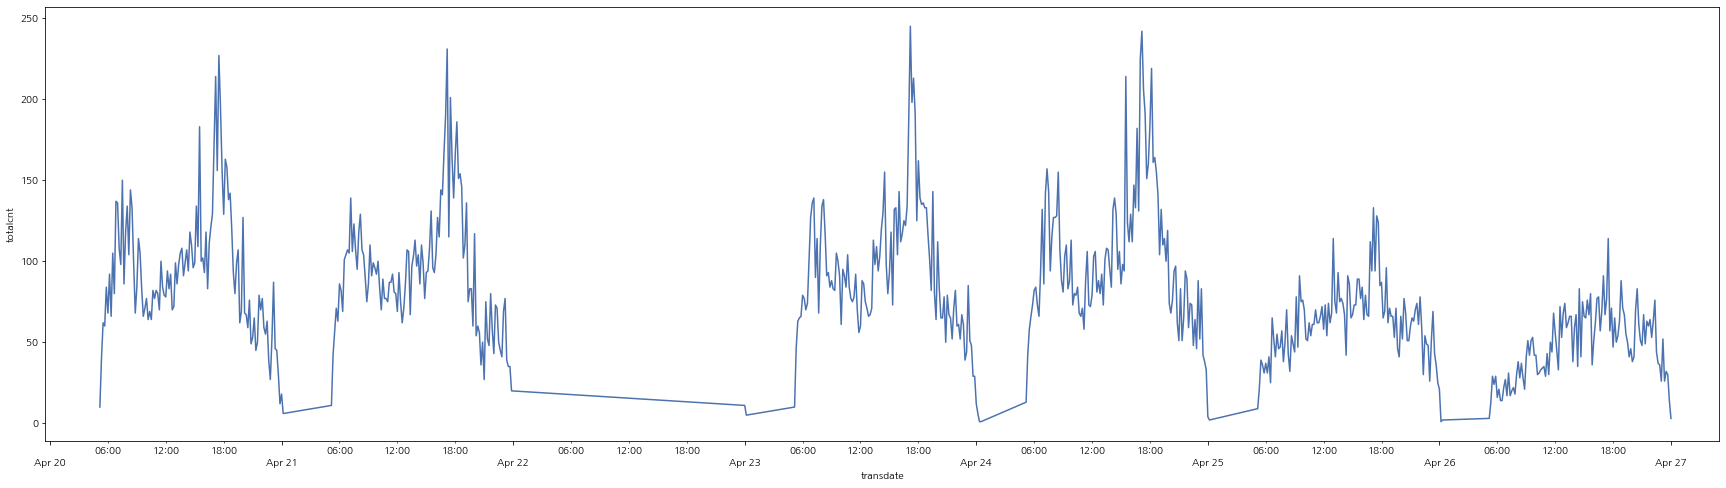

In [421]:
plot_week_cnt(data = mybicard_401, start_dt = "2020-04-20")

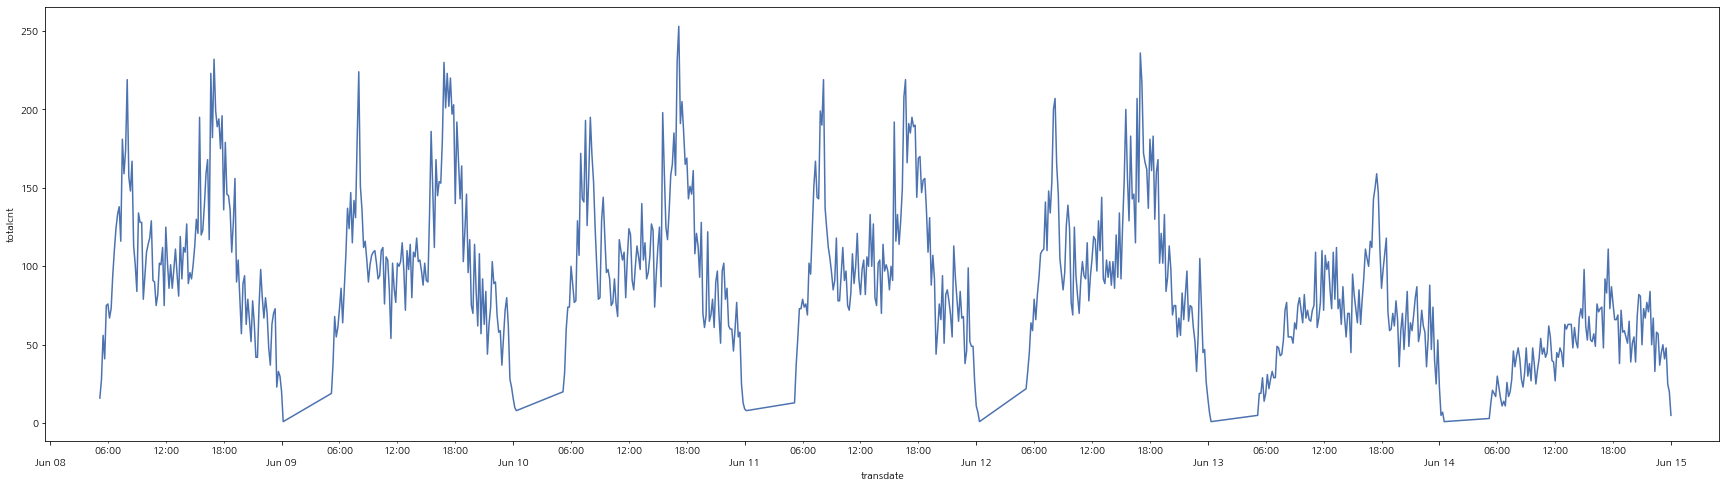

In [420]:
plot_week_cnt(data = mybicard_401, start_dt = "2020-06-08")

In [419]:
plot_week_cnt(data = mybicard_401, start_dt = "2020-09-28")

In [186]:
plot_week_cnt(data = mybicard_401, start_dt = "2020-11-16")

### 월별 탑승 인원 추세

In [66]:
collect_days = count_by_date.loc[count_by_date["cnt"] != 0].groupby(pd.Grouper(key="transdate", freq = "M")).size().reset_index(name = "max_days")

In [67]:
# 13798
mybicard_401_agg_1M = (mybicard_401.loc[(mybicard_401["transflag"] != "하차")]
                                   .groupby(["route_nm", 
#                                              "stop_nm", 
#                                              "stop_id", 
#                                              "longitude", 
#                                              "latitude", 
#                                              "dayofweek",
#                                              "hour",
                                             pd.Grouper(key="transdate", freq='M')])
                                   .agg({"totalcnt" : sum})
                                   .reset_index())

In [68]:
mybicard_401_agg_1M = pd.merge(mybicard_401_agg_1M, collect_days, on = "transdate", how = "inner" )
mybicard_401_agg_1M["mean_cnt"] = mybicard_401_agg_1M["totalcnt"]/mybicard_401_agg_1M["max_days"]

In [69]:
mybicard_401_agg_1M

route_nm  transdate  totalcnt  max_days      mean_cnt
0      401 2020-04-30    139181        15   9278.733333
1      401 2020-05-31    222708        22  10123.090909
2      401 2020-06-30    325604        30  10853.466667
3      401 2020-07-31    353947        31  11417.645161
4      401 2020-08-31    254036        26   9770.615385
5      401 2020-09-30    285996        30   9533.200000
6      401 2020-10-31    153301        16   9581.312500
7      401 2020-11-30    214794        20  10739.700000

In [ ]:
	route_nm	transdate	totalcnt	max_days	mean_cnt
0	401	2020-04-30	139181	15	9278.733333
1	401	2020-05-31	222708	22	10123.090909
2	401	2020-06-30	325604	30	10853.466667
3	401	2020-07-31	353947	31	11417.645161
4	401	2020-08-31	254036	26	9770.615385
5	401	2020-09-30	285996	30	9533.200000
6	401	2020-10-31	153301	16	9581.312500
7	401	2020-11-30	214794	20	10739.700000

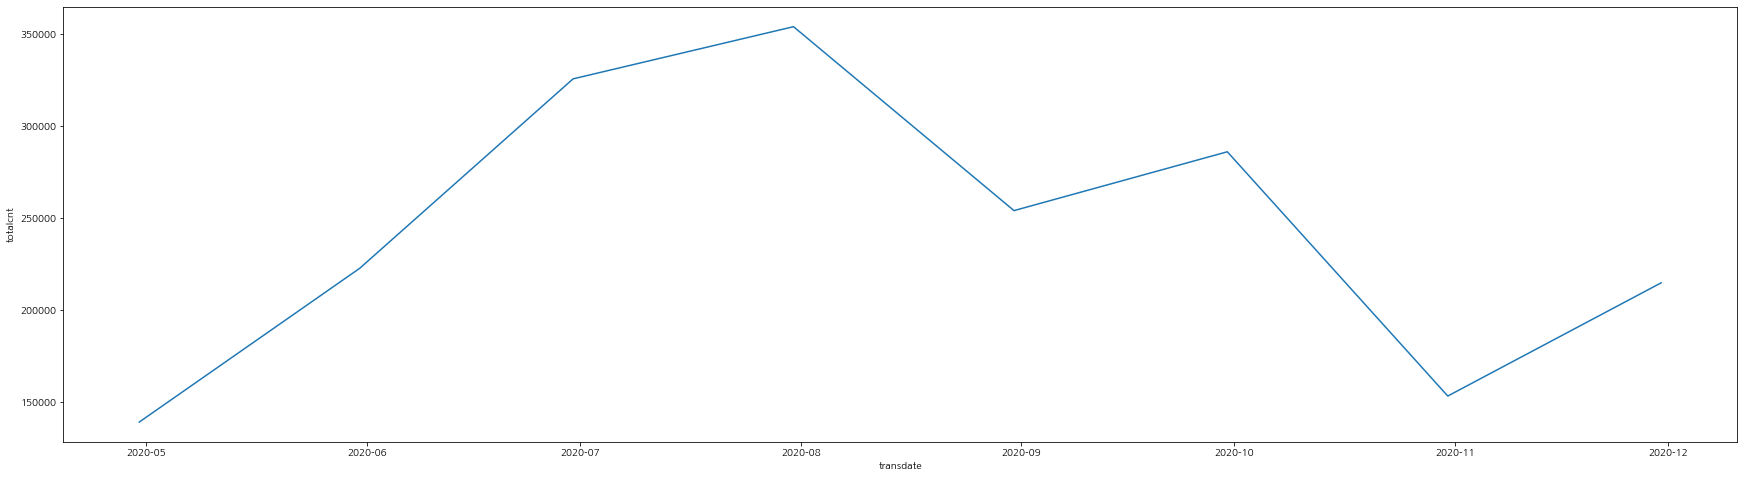

In [80]:
plt.figure(figsize=(30,8))
g = sns.lineplot(data = mybicard_401_agg_1M, x = "transdate", y = "totalcnt")

In [77]:
plt.figure(figsize=(30,8))
g = sns.lineplot(data = mybicard_401_agg_1M, x = "transdate", y = "mean_cnt")
g.set(ylim=(5000, 15000))

[(5000.0, 15000.0)]

### 버스 정류소 위치 정보 데이터

In [15]:
# 경주시, 양산시, 울산광역시, 부산광역시
bus_stop = pd.read_csv("/home/seho/Passenger_Demand/data/울산광역시_버스 정류소 위치 정보_20200531.csv", encoding = "euc-kr")
bus_stop = bus_stop.loc[bus_stop["권역"] == "울산광역시"]
bus_stop.columns = ["stop_nm", "stop_id", "longitude", "latitude", "city"]

In [16]:
bus_stop_401_1 = pd.read_csv("/home/seho/Passenger_Demand/data/401_율리_꽃바위.csv", encoding = "euc_kr")
bus_stop_401_2 = pd.read_csv("/home/seho/Passenger_Demand/data/401_꽃바위_율리.csv", encoding = "euc_kr")
bus_stop_401 = pd.concat([bus_stop_401_1, bus_stop_401_2])
bus_stop_401.columns = ["mybi_stop_id", "stop_id"]

In [17]:
# 마이비 정류장 ID -> 공공 데이터 정류쟝 ID로 매핑
mybicard_401 = pd.merge(mybicard_401, bus_stop_401, on = "mybi_stop_id", how = "inner")

In [18]:
mybicard_401 = pd.merge(mybicard_401, bus_stop[["stop_id", "longitude", "latitude"]], on = "stop_id")

In [189]:
bus_stop_401_1.columns = ["mybi_stop_id", "stop_id"]

In [193]:
temp = pd.merge(bus_stop_401_1, bus_stop, on = "stop_id")

In [195]:
temp

mybi_stop_id  stop_id     stop_nm   longitude   latitude   city
0        3100597    30504     율리공영차고지  129.246863  35.529520  울산광역시
1        3100339    30714    우신고등학교입구  129.255322  35.537435  울산광역시
2        3101462    30712     울산과학대학앞  129.257440  35.539800  울산광역시
3        3101461    30708      울산대학교앞  129.260306  35.543755  울산광역시
4        3100479    30706     울산대학교후문  129.261981  35.546813  울산광역시
..           ...      ...         ...         ...        ...    ...
59       3100085    25008  방어동 행정복지센터  129.423191  35.485595  울산광역시
60       3101466    25006     우성현대아파트  129.418570  35.483520  울산광역시
61       3101465    25004       비치타운앞  129.414839  35.480528  울산광역시
62       3101464    25002          화암  129.411412  35.477671  울산광역시
63       3100439    19016         꽃바위  129.410279  35.478833  울산광역시

[64 rows x 6 columns]

In [206]:
dist_list = []
for i in range(temp.shape[0]):
    if i == temp.shape[0]-1:
        dist_list.append(None)
        continue
    
    this_stop = (temp.iloc[i]["latitude"], temp.iloc[i]["longitude"])
    next_stop = (temp.iloc[i+1]["latitude"], temp.iloc[i+1]["longitude"])
    
    dist_list.append(haversine(this_stop, next_stop))
temp["between_dist"] = dist_list    

In [210]:
temp["between_dist"].describe()

count    63.000000
mean      0.485555
std       0.228853
min       0.164955
25%       0.366061
50%       0.444077
75%       0.529807
max       1.429173
Name: between_dist, dtype: float64

### Folium을 통한 지도 히트맵

In [424]:
import folium
from folium.plugins import HeatMap

### 60분단위 집계

In [425]:
# 314862
mybicard_401_agg_1h = (mybicard_401.loc[mybicard_401["transflag"] != "하차"]
                                   .groupby(["route_nm", 
                                             "stop_nm", 
                                             "stop_id", 
                                             "longitude", 
                                             "latitude", 
                                             "dayofweek",
                                             "hour",
                                             pd.Grouper(key="transdate", freq='60Min')])
                                   .agg({"totalcnt" : sum})
                                   .reset_index())

In [426]:
temp = mybicard_401_agg_1h.loc[(mybicard_401_agg_1h["dayofweek"] == "월") & (mybicard_401_agg_1h["hour"].between(0,24))]

In [427]:
f = folium.Figure(width=1600, height=700)
m = folium.Map([35.539302, 129.338169], zoom_start=13, width=1600, height=700)

In [428]:
HeatMap(temp[['latitude','longitude']]).add_to(m)

In [430]:
HeatMap(temp[['latitude','longitude']]).add_to(m)

f.add_child(m)

## 날씨 데이터

In [19]:
weather_data = pd.read_parquet("~/Passenger_Demand/data/weather_2018.parquet")

In [20]:
weather_data = weather_data.loc[:, ["tm", "ta", "hm", "rn", "dc10Tca",  "dsnw", "wd", "ws"]]
weather_data = weather_data.rename(columns = {"tm" : "시간",
                                              "ta" : "기온",
                                              "hm" : "습도",
                                              "rn" : "강수량",
                                              "dc10Tca" : "전운량",
                                              "dsnw" : "적설량",
                                              "wd" : "풍향",
                                              "ws" : "풍속"})
weather_data["시간"] = pd.to_datetime(weather_data["시간"], format = "%Y-%m-%d %H:%M")

In [21]:
for col in weather_data.columns:
    if col == "시간":
        continue
    print(col)
    weather_data[col] = weather_data[col].replace("", "0.0").astype(float)
    weather_data[col] = weather_data[col].astype(float)

기온
습도
강수량
전운량
적설량
풍향
풍속


In [22]:
weather_data["time_hours"] = weather_data["시간"].dt.strftime("%Y-%m-%d %H")

In [23]:
mybicard_401["transdate_hours"] = mybicard_401["transdate"].dt.strftime("%Y-%m-%d %H")

In [24]:
mybicard_401_wt = pd.merge(mybicard_401, weather_data, left_on = "transdate_hours", right_on = "time_hours")
mybicard_401_wt = mybicard_401_wt.drop(["transdate_hours", "time_hours", "시간"], 1)

### 기온과 탑승률의 상관관계

In [432]:
pd.set_option("display.max_columns", None)

In [433]:
mybicard_401_agg_1h = (mybicard_401_wt.loc[mybicard_401["transflag"] != "하차"]
                                   .groupby([pd.Grouper(key="transdate", freq='60Min')])
                                   .agg({"totalcnt" : sum,
                                         "기온" : np.mean,
                                         "습도" : np.mean,
                                         "강수량" : np.mean,
                                         "적설량" : np.mean
                                         })
                                   .reset_index())

<AxesSubplot:xlabel='기온', ylabel='totalcnt'>

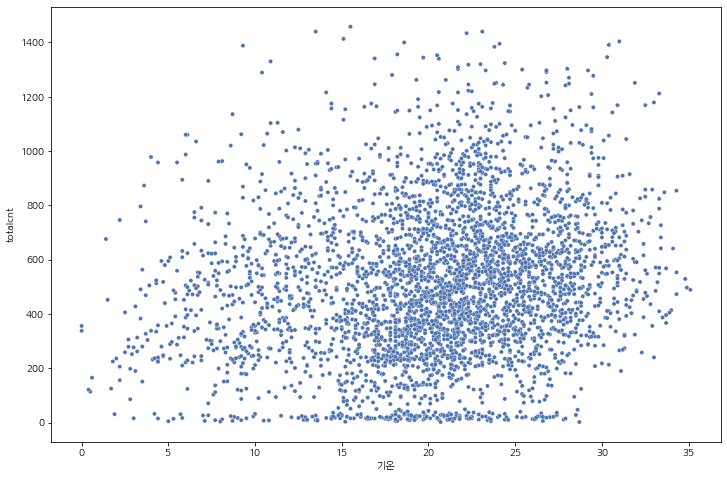

In [437]:
plt.figure(figsize=(12,8))
sns.scatterplot(data = mybicard_401_agg_1h, x = "기온", y = "totalcnt", size = 3, legend=False)

<AxesSubplot:xlabel='습도', ylabel='totalcnt'>

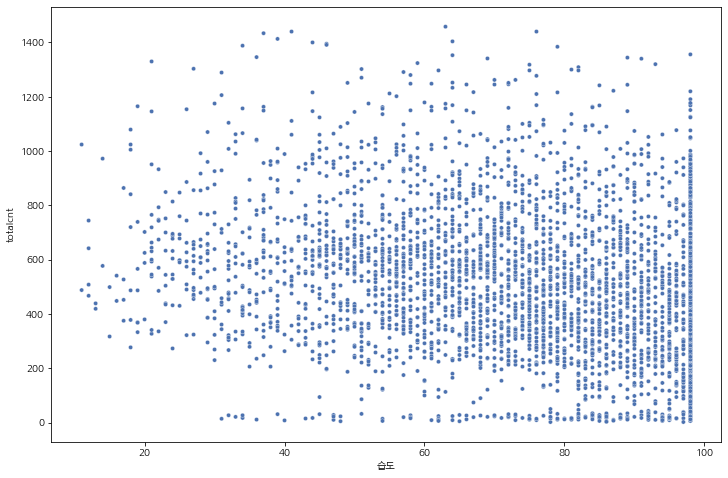

In [438]:
plt.figure(figsize=(12,8))
sns.scatterplot(data = mybicard_401_agg_1h, x = "습도", y = "totalcnt", size = 3, legend=False)

<AxesSubplot:xlabel='강수량', ylabel='totalcnt'>

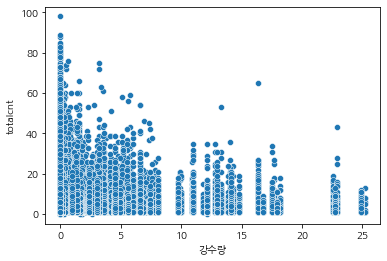

In [79]:
sns.scatterplot(data = mybicard_401_agg_1h, x = "강수량", y = "totalcnt")

<AxesSubplot:xlabel='적설량', ylabel='totalcnt'>

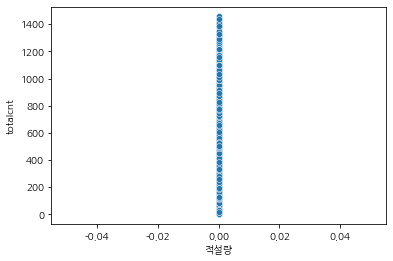

In [398]:
sns.scatterplot(data = mybicard_401_agg_1h, x = "적설량", y = "totalcnt")

In [26]:
accident_data = pd.read_parquet("/home/seho/Passenger_Demand/data/accident_data.parquet")

In [57]:
accident_data.value_counts("edsr_knd_nm")

edsr_knd_nm
구급    33753
구조    13315
기타     5984
화재     1395
dtype: int64

In [220]:
accident_data["edsr_cls_nm"].value_counts().head(10)

질병외       9806
질병        7846
구급기타      7740
기타안전사고    4515
교통사고      3766
벌집제거      3672
예방경계      2640
사고부상      2579
기타출동      2417
부상        2039
Name: edsr_cls_nm, dtype: int64

In [61]:
accident_data.value_counts(["edsr_knd_nm", "edsr_cls_nm"]).to_csv("사고 유형.csv")

In [59]:
accident_data.loc[accident_data["edsr_cls_nm"] == "교통사고", "edsr_knd_nm"].value_counts()

구급    2402
구조    1364
Name: edsr_knd_nm, dtype: int64

In [27]:
pd.set_option("display.max_columns", None)

In [28]:
mybicard_401_wt.shape

(1964401, 31)

In [257]:
# 314862
mybicard_401_agg_1h = (mybicard_401_wt.loc[mybicard_401_wt["transflag"] != "하차"]
                                   .groupby(["route_nm", 
                                             "stop_nm", 
                                             "stop_id", 
                                             "longitude", 
                                             "latitude", 
                                             "dayofweek",
                                             "hour",
                                             pd.Grouper(key="transdate", freq='60Min')])
                                   .agg({"totalcnt" : sum,
                                         "기온" : np.mean,
                                         "습도" : np.mean,
                                         "강수량" : np.mean,
                                         "적설량" : np.mean})
                                   .sort_values("transdate")
                                   .reset_index())

In [258]:
#############################################################
# 분석과제 : 
# 설    명 : 데이터 프레임을 병렬처리하는 함수
# RAW DATA : 
# 분석기법 : 
# 작성일자 : 2020.06.01
# 수정일자 : 2020.06.01
# 파일버전 : v0.1
# 작 성 자 : 박세호
############################################################

from multiprocessing_on_dill import Pool, cpu_count
from functools import partial
import pandas as pd
import numpy as np

def parallelize_dataframe(df, 
                          func, 
                          group_keys = None, 
                          num_cores = None,
                          **params):
    """
        Pandas DataFrame의 apply함수를 병렬처리 하는 함수

        Args: 
            df: 적용 대상 데이터프레임 (Pandas.DataFrame)
            group_keys: apply를 적용할 때 기준이되는 group by key

        Returns:
            df: (Pandas.DataFrame)
            
        Exception: 
    """

    if num_cores is None:
        num_cores = cpu_count()

    if group_keys is None:
        df_list = np.array_split(df, num_cores)
    elif group_keys is not None:
        gr_df = df.groupby(group_keys)
        df_list = [group for name, group in gr_df]
    
#     func = partial(func, **params)
    
    def map_func(data):
        return data.apply(func, axis = 1, **params)
        
        
    with Pool(num_cores) as p:

        pd_result = pd.concat(p.map(map_func, df_list))
#         pd_result = p.starmap(func, **params)
        
    return pd_result

In [254]:
def count_accident_nearby(data, accident_data = accident_data, dist = 0.1, minutes = 15):
    data_copy = data.copy()
    within_data = accident_data.loc[(accident_data["rcpt_dt"].between(data_copy["transdate"] - timedelta(minutes = minutes), data_copy["transdate"]))]
    if within_data.empty:
        data_copy["accident_nearby"] = 0
        data_copy["disease_etc_nearby"] = 0
        data_copy["disease_nearby"] = 0
        data_copy["emergency_nearby"] = 0
        data_copy["safety_accident_nearby"] = 0
        data_copy["car_accident_nearby"] = 0
        
    else:
        dist_list = within_data.apply(lambda x: haversine((x["lat"], x["lng"]), (data_copy["latitude"], data_copy["longitude"])), 1)
        within_data = within_data.loc[dist_list <= dist]
        
        data_copy["accident_nearby"] = within_data.shape[0]
        data_copy["disease_etc_nearby"] = (within_data["edsr_cls_nm"] == "질병외").sum()
        data_copy["disease_nearby"] = (within_data["edsr_cls_nm"] == "질병").sum()
        data_copy["emergency_nearby"] = (within_data["edsr_cls_nm"] == "구급기타").sum()
        data_copy["safety_accident_nearby"] = (within_data["edsr_cls_nm"] == "기타안전사고").sum()
        data_copy["car_accident_nearby"] = (within_data["edsr_cls_nm"] == "교통사고").sum()
        
    return data_copy
    

In [262]:
%%time
mybicard_401_agg_1h = parallelize_dataframe(df = mybicard_401_agg_1h, func = count_accident_nearby, num_cores = 12, accident_data = accident_data, dist = 3, minutes=15)

CPU times: user 5.53 s, sys: 604 ms, total: 6.14 s
Wall time: 3min


In [292]:
mybicard_401_agg_1h.loc[mybicard_401_agg_1h["accident_nearby"] > 4].head(20)

route_nm           stop_nm  stop_id   longitude   latitude dayofweek  \
62948      401            서여자중학교    40611  129.300466  35.533292         화   
62952      401            신정고등학교    40613  129.303124  35.532860         화   
88480      401            서여자중학교    40611  129.300466  35.533292         수   
88485      401             목화예식장    40415  129.330705  35.537894         수   
88486      401              롯데마트    40407  129.317043  35.534562         수   
88491      401             목화예식장    40416  129.330419  35.538175         수   
88493      401                법원    40605  129.288882  35.535148         수   
88496      401             굿모닝병원    40410  129.320548  35.535820         수   
88502      401           달동현대아파트    40411  129.323741  35.536306         수   
88516      401            옥동초등학교    40607  129.295993  35.534013         수   
88519      401           달동현대아파트    40412  129.323186  35.536507         수   
88521      401            신정고등학교    40613  129.303124  35.532860         수   
88525      401               공업탑    40403  129.310320  35.532811         수   
88533      401  옥동행정복지센터.울산대공원정문    40608  129.293355  35.534762         수   
88535      401            신정고등학교    40614  129.302470  35.533288         수   
88536      401              현대해상    40413  129.326594  35.537051         수   
88540      401         시외고속버스터미널    40419  129.338169  35.539302         수   
88541      401            옥동초등학교    40610  129.297240  35.534136         수   
88543      401              롯데마트    40408  129.316297  35.534711         수   
88546      401             현대백화점    40417  129.333958  35.538509         수   

       hour           transdate  totalcnt    기온    습도  강수량  적설량  \
62948    10 2020-06-02 10:00:00         9  25.2  28.0  0.0  0.0   
62952    10 2020-06-02 10:00:00        11  25.2  28.0  0.0  0.0   
88480    14 2020-06-17 14:00:00         4  25.1  44.0  0.0  0.0   
88485    14 2020-06-17 14:00:00         4  25.1  44.0  0.0  0.0   
88486    14 2020-06-17 14:00:00        17  25.1  44.0  0.0  0.0   
88491    14 2020-06-17 14:00:00         8  25.1  44.0  0.0  0.0   
88493    14 2020-06-17 14:00:00         8  25.1  44.0  0.0  0.0   
88496    14 2020-06-17 14:00:00         7  25.1  44.0  0.0  0.0   
88502    14 2020-06-17 14:00:00        14  25.1  44.0  0.0  0.0   
88516    14 2020-06-17 14:00:00        17  25.1  44.0  0.0  0.0   
88519    14 2020-06-17 14:00:00         3  25.1  44.0  0.0  0.0   
88521    14 2020-06-17 14:00:00         8  25.1  44.0  0.0  0.0   
88525    14 2020-06-17 14:00:00        22  25.1  44.0  0.0  0.0   
88533    14 2020-06-17 14:00:00         6  25.1  44.0  0.0  0.0   
88535    14 2020-06-17 14:00:00         5  25.1  44.0  0.0  0.0   
88536    14 2020-06-17 14:00:00         6  25.1  44.0  0.0  0.0   
88540    14 2020-06-17 14:00:00        31  25.1  44.0  0.0  0.0   
88541    14 2020-06-17 14:00:00         3  25.1  44.0  0.0  0.0   
88543    14 2020-06-17 14:00:00         1  25.1  44.0  0.0  0.0   
88546    14 2020-06-17 14:00:00         8  25.1  44.0  0.0  0.0   

       accident_nearby  disease_etc_nearby  disease_nearby  emergency_nearby  \
62948                5                   0               1                 0   
62952                5                   0               1                 0   
88480                5                   0               1                 1   
88485                5                   0               1                 1   
88486                6                   0               1                 1   
88491                5                   0               1                 1   
88493                5                   0               1                 1   
88496                6                   0               1                 1   
88502                6                   0               1                 1   
88516                5                   0               1                 1   
88519                6                   0               1                 1   

In [279]:
def plot_week_cnt(data, start_dt = "2020-04-20"):
#     data_grp = (data.loc[(data["transflag"] != "하차")]
#                     .groupby(["route_nm", 
#                               pd.Grouper(key="transdate", freq='10Min')])
#                     .agg({"totalcnt" : sum})
#                     .reset_index())
    

    start_dt = datetime.strptime(start_dt, "%Y-%m-%d") + timedelta(hours=5)
    end_dt = start_dt + timedelta(days=6, hours = 19)
    
    data = data.loc[data["transdate"].between(start_dt, end_dt)]    
    
    plt.figure(figsize=(30,8))
    g = sns.lineplot(data = data, x = "transdate", y = "totalcnt")
    
    g.set(xlim=(start_dt - timedelta(hours=5,minutes=30), end_dt + timedelta(hours=5)))
    g.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
    g.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M\n'))
    g.xaxis.set_major_locator(mdates.DayLocator())
    g.xaxis.set_major_formatter(mdates.DateFormatter('\n%b %d'))

    plt.show()

In [300]:
start_dt = "2020-06-17"

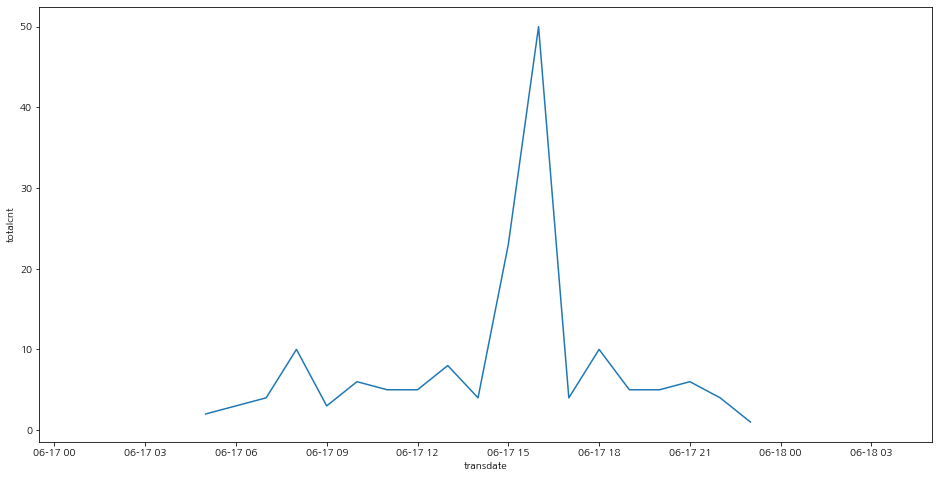

In [302]:
start_dt = "2020-06-17"
start_dt = datetime.strptime(start_dt, "%Y-%m-%d") + timedelta(hours=5)
end_dt = start_dt + timedelta(hours = 19)

plt.figure(figsize=(16,8))
g = sns.lineplot(data = mybicard_401_agg_1h.loc[(mybicard_401_agg_1h["stop_id"] == 40611) & (mybicard_401_agg_1h["transdate"].between(start_dt, end_dt))], x = "transdate", y = "totalcnt")
g.set(xlim=(start_dt - timedelta(hours=5,minutes=30), end_dt + timedelta(hours=5)))
g.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
plt.show()

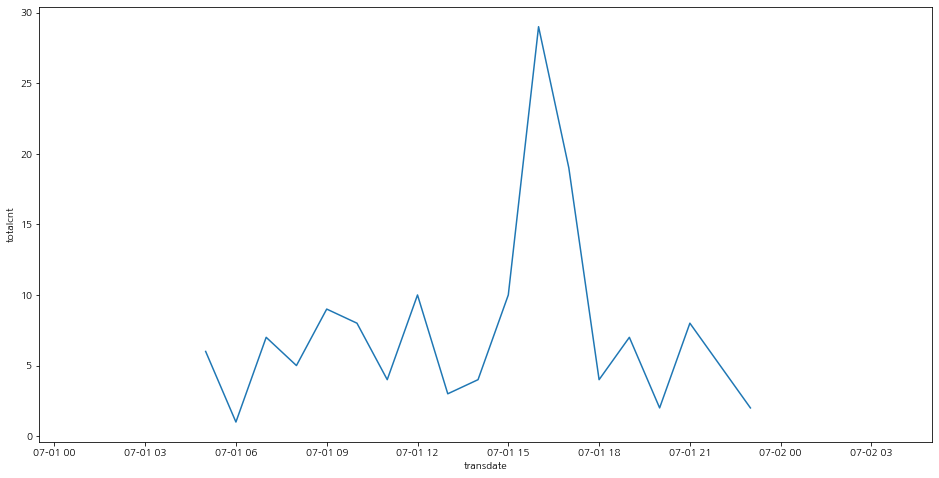

In [307]:
start_dt = "2020-07-01"
start_dt = datetime.strptime(start_dt, "%Y-%m-%d") + timedelta(hours=5)
end_dt = start_dt + timedelta(hours = 19)

plt.figure(figsize=(16,8))
g = sns.lineplot(data = mybicard_401_agg_1h.loc[(mybicard_401_agg_1h["stop_id"] == 40611) & (mybicard_401_agg_1h["transdate"].between(start_dt, end_dt))], x = "transdate", y = "totalcnt")
g.set(xlim=(start_dt - timedelta(hours=5,minutes=30), end_dt + timedelta(hours=5)))
g.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
plt.show()

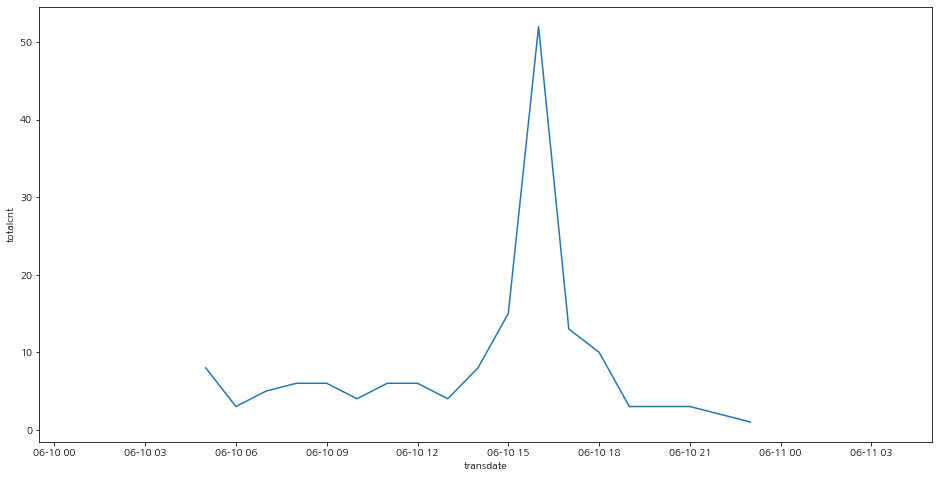

In [303]:
start_dt = "2020-06-10"
start_dt = datetime.strptime(start_dt, "%Y-%m-%d") + timedelta(hours=5)
end_dt = start_dt + timedelta(hours = 19)

plt.figure(figsize=(16,8))
g = sns.lineplot(data = mybicard_401_agg_1h.loc[(mybicard_401_agg_1h["stop_id"] == 40611) & (mybicard_401_agg_1h["transdate"].between(start_dt, end_dt))], x = "transdate", y = "totalcnt")
g.set(xlim=(start_dt - timedelta(hours=5,minutes=30), end_dt + timedelta(hours=5)))
g.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
plt.show()

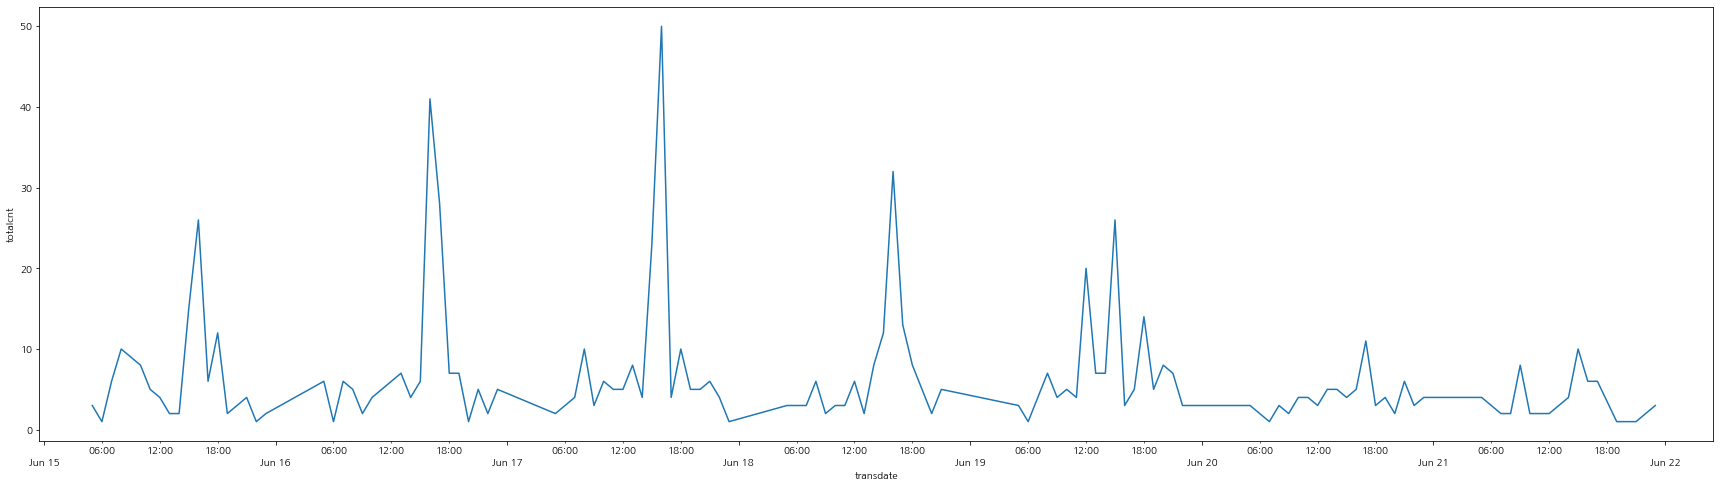

In [295]:
plot_week_cnt(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["stop_id"] == 40611], start_dt = "2020-06-15")

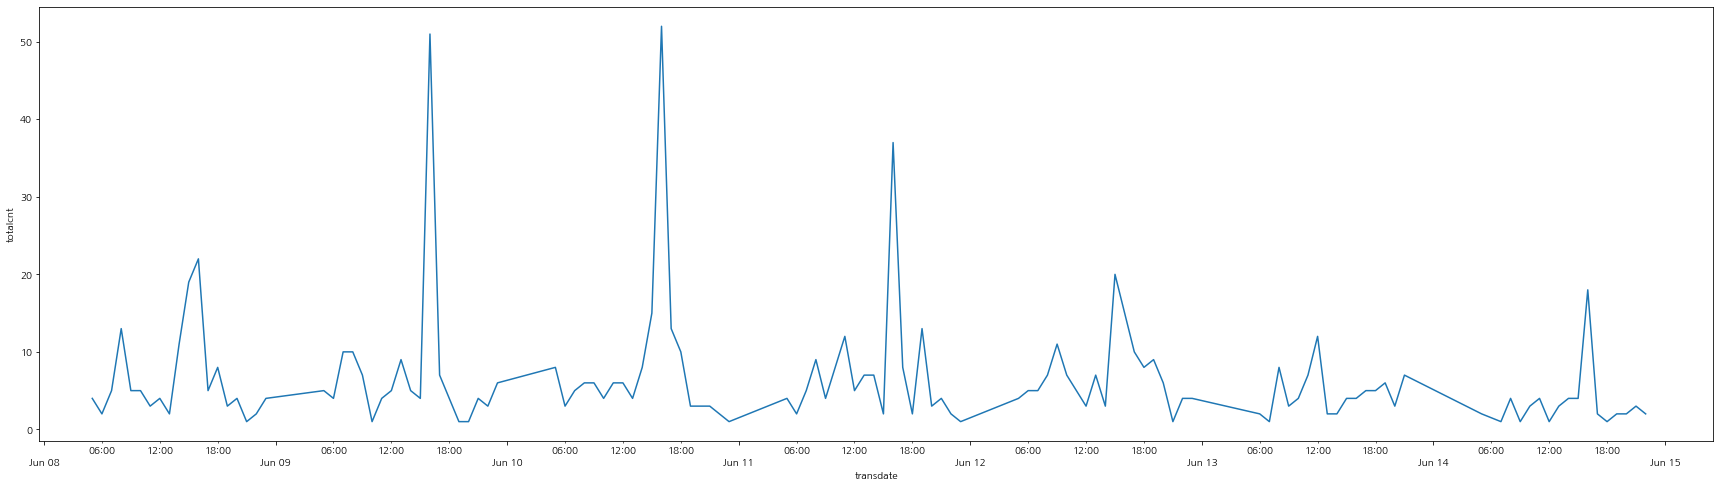

In [297]:
plot_week_cnt(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["stop_id"] == 40611], start_dt = "2020-06-10")

### 시간대별(0-6, 7-12, 13-18, 19-24) 신고접수 횟수와 탑승수 관계

<AxesSubplot:xlabel='accident_nearby', ylabel='totalcnt'>

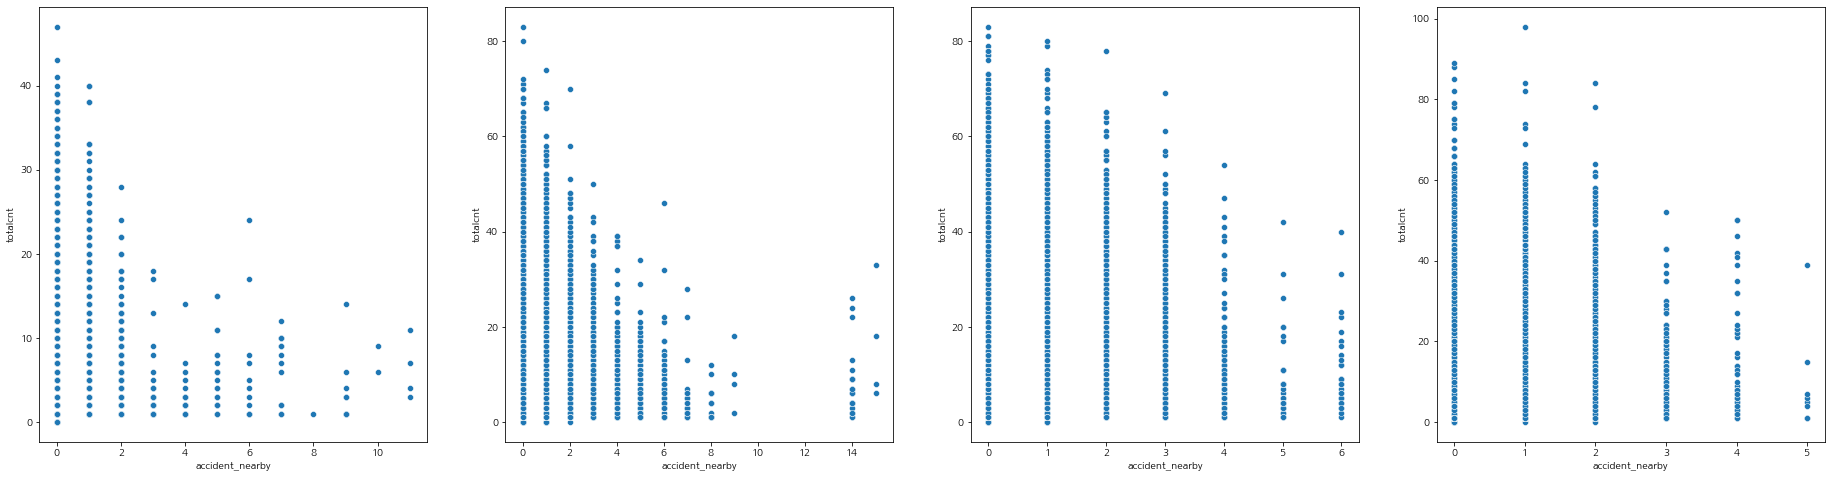

In [264]:
fig, ax = plt.subplots(ncols = 4, figsize=(32,8)) 
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(0, 6)], x = "accident_nearby", y = "totalcnt", ax = ax[0])
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(7, 12)], x = "accident_nearby", y = "totalcnt", ax = ax[1])
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(13, 18)], x = "accident_nearby", y = "totalcnt", ax = ax[2])
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(19, 24)], x = "accident_nearby", y = "totalcnt", ax = ax[3])

<AxesSubplot:xlabel='disease_etc_nearby', ylabel='totalcnt'>

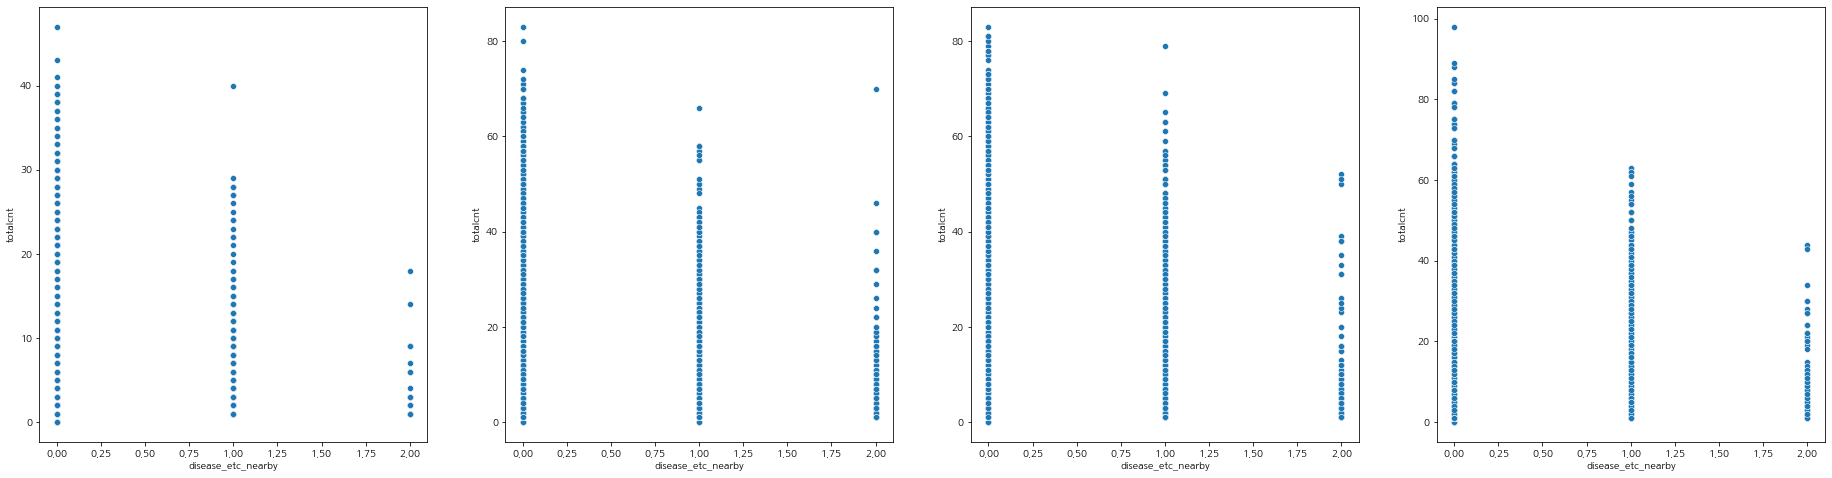

In [265]:
fig, ax = plt.subplots(ncols = 4, figsize=(32,8))
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(0, 6)], x = "disease_etc_nearby", y = "totalcnt", ax = ax[0])
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(7, 12)], x = "disease_etc_nearby", y = "totalcnt", ax = ax[1])
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(13, 18)], x = "disease_etc_nearby", y = "totalcnt", ax = ax[2])
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(19, 24)], x = "disease_etc_nearby", y = "totalcnt", ax = ax[3])

<AxesSubplot:xlabel='disease_nearby', ylabel='totalcnt'>

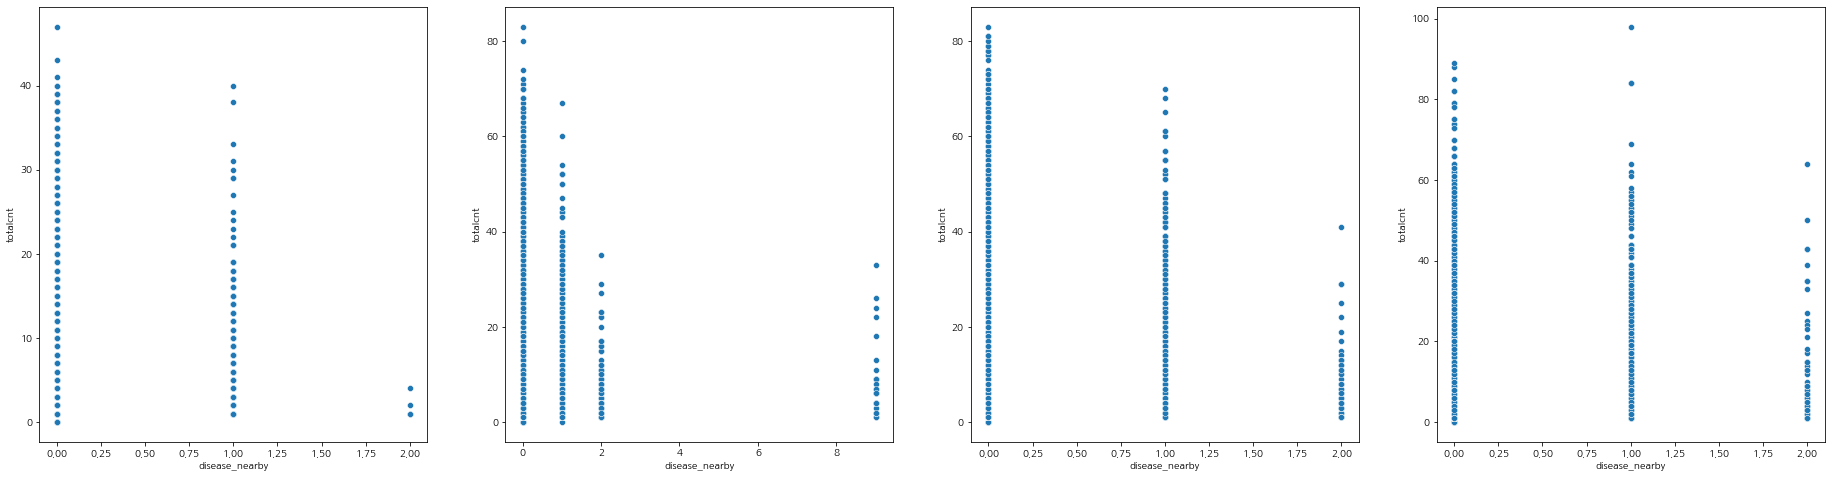

In [266]:
fig, ax = plt.subplots(ncols = 4, figsize=(32,8))
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(0, 6)], x = "disease_nearby", y = "totalcnt", ax = ax[0])
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(7, 12)], x = "disease_nearby", y = "totalcnt", ax = ax[1])
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(13, 18)], x = "disease_nearby", y = "totalcnt", ax = ax[2])
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(19, 24)], x = "disease_nearby", y = "totalcnt", ax = ax[3])

<AxesSubplot:xlabel='emergency_nearby', ylabel='totalcnt'>

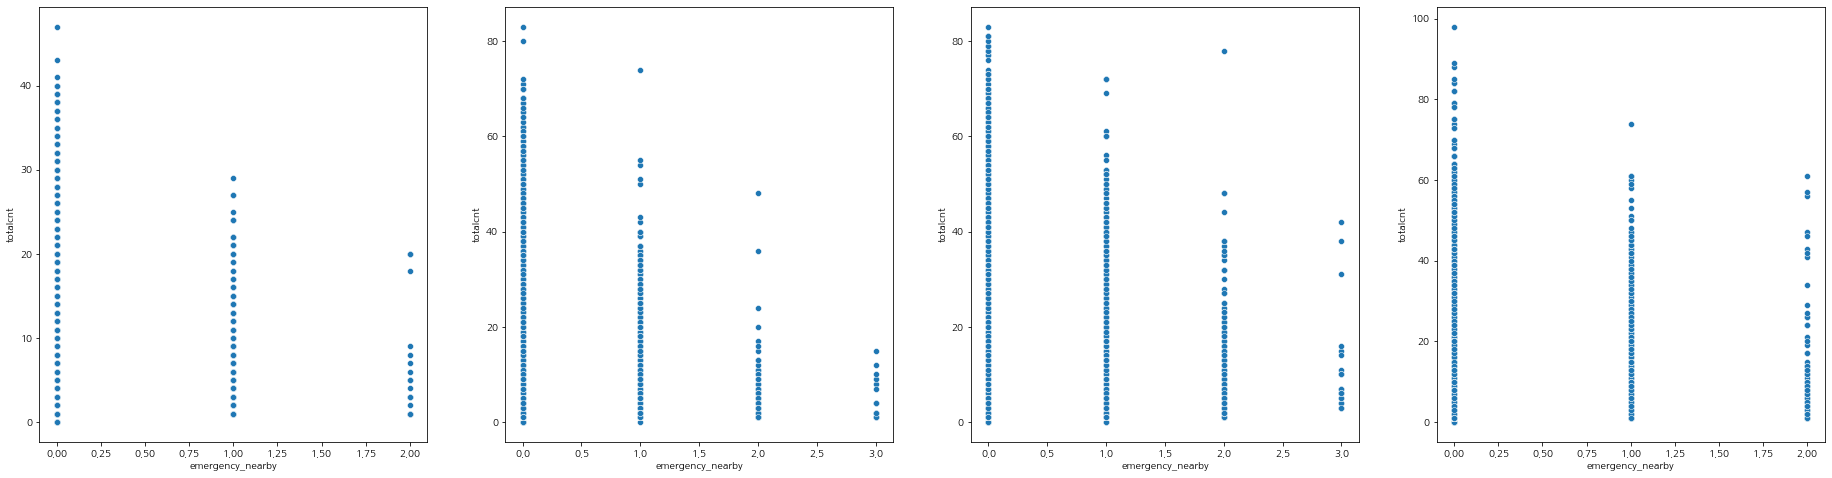

In [267]:
fig, ax = plt.subplots(ncols = 4, figsize=(32,8))
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(0, 6)], x = "emergency_nearby", y = "totalcnt", ax = ax[0])
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(7, 12)], x = "emergency_nearby", y = "totalcnt", ax = ax[1])
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(13, 18)], x = "emergency_nearby", y = "totalcnt", ax = ax[2])
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(19, 24)], x = "emergency_nearby", y = "totalcnt", ax = ax[3])

<AxesSubplot:xlabel='safety_accident_nearby', ylabel='totalcnt'>

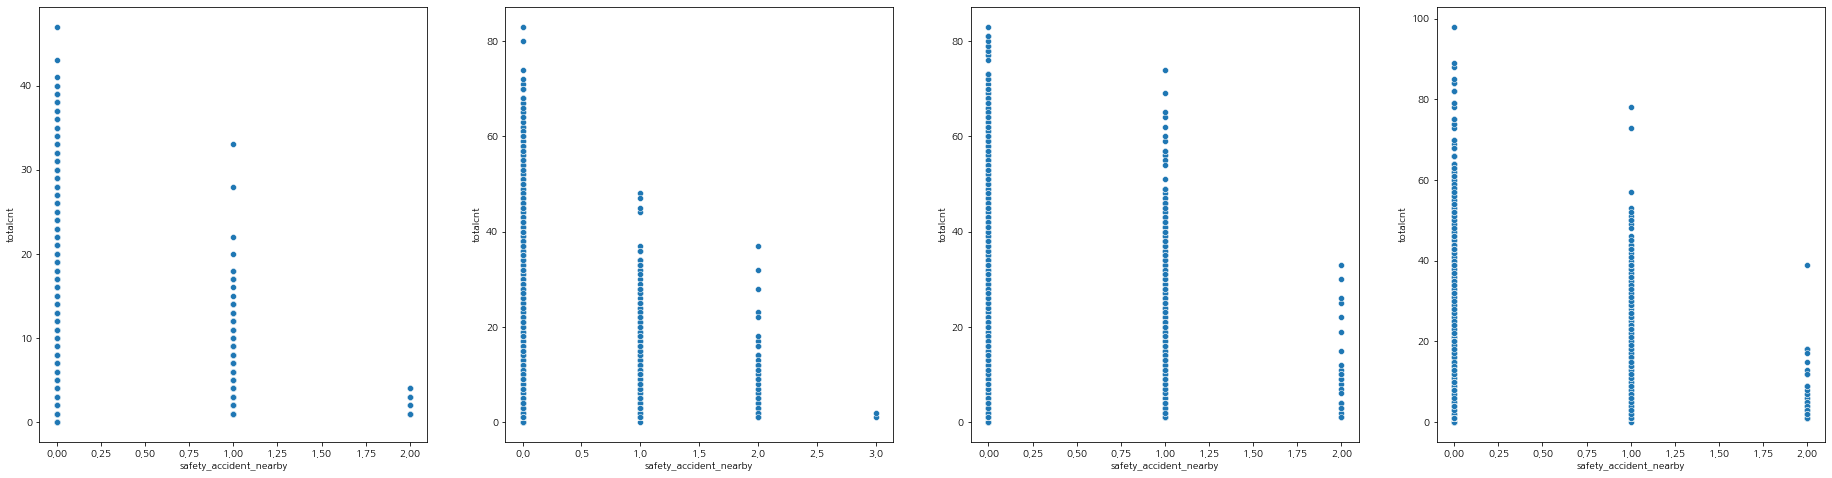

In [268]:
fig, ax = plt.subplots(ncols = 4, figsize=(32,8))
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(0, 6)], x = "safety_accident_nearby", y = "totalcnt", ax = ax[0])
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(7, 12)], x = "safety_accident_nearby", y = "totalcnt", ax = ax[1])
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(13, 18)], x = "safety_accident_nearby", y = "totalcnt", ax = ax[2])
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(19, 24)], x = "safety_accident_nearby", y = "totalcnt", ax = ax[3])

<AxesSubplot:xlabel='car_accident_nearby', ylabel='totalcnt'>

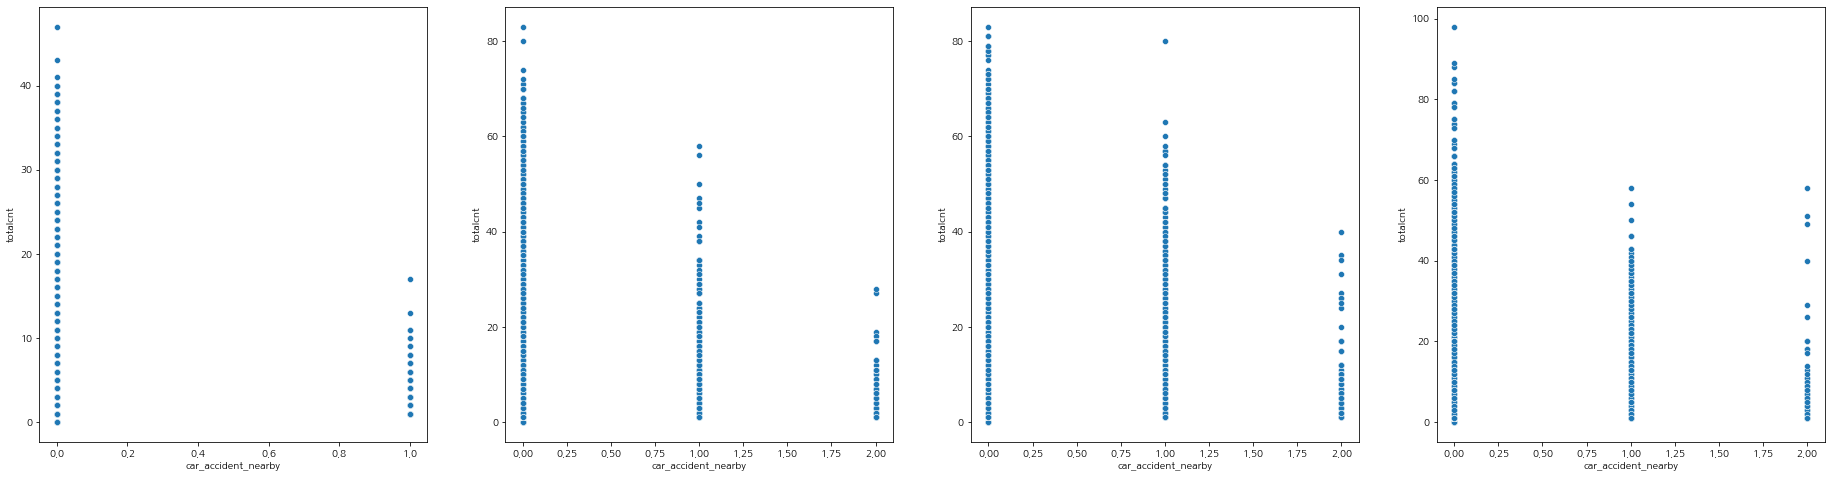

In [269]:
fig, ax = plt.subplots(ncols = 4, figsize=(32,8))
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(0, 6)], x = "car_accident_nearby", y = "totalcnt", ax = ax[0])
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(7, 12)], x = "car_accident_nearby", y = "totalcnt", ax = ax[1])
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(13, 18)], x = "car_accident_nearby", y = "totalcnt", ax = ax[2])
sns.scatterplot(data = mybicard_401_agg_1h.loc[mybicard_401_agg_1h["transdate"].dt.hour.between(19, 24)], x = "car_accident_nearby", y = "totalcnt", ax = ax[3])

In [308]:
mybicard_401_agg_1h

route_nm      stop_nm  stop_id   longitude   latitude dayofweek  hour  \
0           401        동부경찰서    24227  129.429961  35.507814         수     0   
1           401           법원    40606  129.288879  35.535474         수     0   
2           401  현대중공업울산대학병원    24219  129.432616  35.522595         수     0   
3           401     서부패밀리아파트    24215  129.432981  35.528849         수     0   
4           401         남목1동    24209  129.425575  35.539325         수     0   
...         ...          ...      ...         ...        ...       ...   ...   
314857      401       ??????    40611  129.300466  35.533292         월    23   
314858      401       ??????    24225  129.430550  35.511625         월    23   
314859      401         ??1?    24210  129.425723  35.539526         월    23   
314860      401      ???????    30622  129.382709  35.550766         월    23   
314861      401          ???    40403  129.310320  35.532811         월    23   

                 transdate  totalcnt    기온    습도  강수량  적설량  accident_nearby  \
0      2020-04-08 00:00:00         1  12.8  47.0  0.0  0.0                0   
1      2020-04-08 00:00:00         1  12.8  47.0  0.0  0.0                0   
2      2020-04-08 00:00:00         2  12.8  47.0  0.0  0.0                0   
3      2020-04-08 00:00:00         1  12.8  47.0  0.0  0.0                0   
4      2020-04-08 00:00:00         2  12.8  47.0  0.0  0.0                0   
...                    ...       ...   ...   ...  ...  ...              ...   
314857 2020-11-30 23:00:00         3   2.8  46.0  0.0  0.0                1   
314858 2020-11-30 23:00:00         1   2.8  46.0  0.0  0.0                0   
314859 2020-11-30 23:00:00         6   2.8  46.0  0.0  0.0                0   
314860 2020-11-30 23:00:00         1   2.8  46.0  0.0  0.0                0   
314861 2020-11-30 23:00:00         6   2.8  46.0  0.0  0.0                1   

        disease_etc_nearby  disease_nearby  emergency_nearby  \
0                        0               0                 0   
1                        0               0                 0   
2                        0               0                 0   
3                        0               0                 0   
4                        0               0                 0   
...                    ...             ...               ...   
314857                   0               0                 0   
314858                   0               0                 0   
314859                   0               0                 0   
314860                   0               0                 0   
314861                   0               0                 0   

        safety_accident_nearby  car_accident_nearby  
0                            0                    0  
1                            0                    0  
2                            0                    0  
3                            0                    0  
4                            0                    0  
...                        ...                  ...  
314857                       1                    0  
314858                       0                    0  
314859                       0                    0  
314860                       0                    0  
314861                       1                    0  

[314862 rows x 19 columns]

## 상권정보

In [309]:
trading_area = pd.read_csv("/home/seho/Passenger_Demand/data/울산광역시_상권정보_201231.csv")

In [310]:
trading_area

상가업소번호        상호명    지점명 상권업종대분류코드 상권업종대분류명 상권업종중분류코드   상권업종중분류명  \
0      20736666  삼산프리미어어학원    NaN         R    학문/교육       R04      학원-어학   
1      24090929  왕생이입시단과학원    NaN         R    학문/교육       R01  학원-보습교습입시   
2      21683173     이벤트기획연    NaN         F    생활서비스       F20     행사/이벤트   
3      25269148      압구정커피    NaN         Q       음식       Q01         한식   
4      21652277        쿨스쿨    NaN         R    학문/교육       R13     학문교육기타   
...         ...        ...    ...       ...      ...       ...        ...   
52183  17224543    제이에이치공조    NaN         F    생활서비스       F15       주택수리   
52184  17224546       대명공조    NaN         F    생활서비스       F15       주택수리   
52185  17216622     브레맨음악대    NaN         R    학문/교육       R05  학원-음악미술무용   
52186  17221666       GS25  서부현대점         D       소매       D03      종합소매점   
52187  17223805    가네샤사주타로    NaN         F    생활서비스       F11      개인서비스   

      상권업종소분류코드     상권업종소분류명 표준산업분류코드        표준산업분류명  시도코드    시도명  시군구코드 시군구명  \
0        R04A01    학원-외국어/어학   P85502          외국어학원    31  울산광역시  31140   남구   
1        R01A01        학원-입시   P85501       일반 교과 학원    31  울산광역시  31140   남구   
2        F20A02        이벤트기획   N75992    전시 및 행사 대행업    31  울산광역시  31140   남구   
3        Q01A01    한식/백반/한정식   I56111        한식 음식점업    31  울산광역시  31710  울주군   
4        R13A01        학습지보급   P85503       방문 교육 학원    31  울산광역시  31140   남구   
...         ...          ...      ...            ...   ...    ...    ...  ...   
52183    F15A03      배관난방보일러   F42201  배관 및 냉·난방 공사업    31  울산광역시  31110   중구   
52184    F15A03      배관난방보일러   F42201  배관 및 냉·난방 공사업    31  울산광역시  31170   동구   
52185    R05A02  피아노/바이올린/기타   P85620          예술 학원    31  울산광역시  31200   북구   
52186    D03A01          편의점   G47122        체인화 편의점    31  울산광역시  31170   동구   
52187    F11A02       운명감정작명   S96992   점술 및 유사 서비스업    31  울산광역시  31140   남구   

            행정동코드  행정동명         법정동코드 법정동명          지번코드  대지구분코드 대지구분명  지번본번지  \
0      3114057000   삼산동  3.114011e+09  삼산동  3.114010e+18       1    대지   1546   
1      3114055000  신정5동  3.114010e+09  신정동  3.114010e+18       1    대지     80   
2      3114055000  신정5동  3.114010e+09  신정동  3.114060e+18       1    대지    236   
3      3171038000   상북면  3.171038e+09  상북면  3.171040e+18       1    대지    509   
4      3114052000  신정2동  3.114010e+09  신정동  3.114010e+18       1    대지   1216   
...           ...   ...           ...  ...           ...     ...   ...    ...   
52183  3111062000  병영1동  3.111012e+09  남외동  3.111010e+18       1    대지   1016   
52184  3117051000   방어동  3.117010e+09  방어동  3.117010e+18       1    대지    909   
52185  3120054000   강동동  3.120012e+09  산하동  3.120010e+18       2     산     49   
52186  3117059000  남목2동  3.117011e+09  서부동  3.117010e+18       1    대지    257   
52187  3114051000  신정1동  3.114010e+09  신정동  3.114010e+18       1    대지   1880   

       지번부번지                       지번주소         도로명코드                도로명  \
0        3.0        울산광역시 남구 삼산동 1546-3  3.114030e+11       울산광역시 남구 돋질로   
1       19.0         울산광역시 남구 신정동 80-19  3.114040e+11  울산광역시 남구 월평로147번길   
2      107.0       울산광역시 남구 신정동 236-107  3.114030e+11       울산광역시 남구 월평로   
3       14.0  울산광역시 울주군 상북면 궁근정리 509-14  3.171030e+11  울산광역시 울주군 상북면 석남로   
4       17.0       울산광역시 남구 신정동 1216-17  3.114040e+11   울산광역시 남구 봉월로14번길   
...      ...                        ...           ...                ...   
52183    2.0        울산광역시 중구 남외동 1016-2  3.111040e+11    울산광역시 중구 해오름16길   
52184    4.0         울산광역시 동구 방어동 909-4  3.117040e+11       울산광역시 동구 화진길   
52185    NaN           울산광역시 북구 산하동 산49  3.120030e+11    울산광역시 북구 강동산하5로   
52186    4.0         울산광역시 동구 서부동 257-4  3.117020e+11   울산광역시 동구 방어진순환도로   
52187    NaN          울산광역시 남구 신정동 1880  3.114030e+11       울산광역시 남구 봉월로   

       건물본번지  건물부번지        건물관리번호         건물명                  도로명주소   구우편번호  \
0        286    NaN  3.114010e+24         NaN       울산광역시 남구 돋질로 286  680816   
1          5    NaN  3.114010e+24         NaN    울산광역시 남구 월평로147번